# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself. Everyone will get slightly different results depending on their machine.

Writing performant code is extremely important in scientific computing, but also can often be quite mysterious and confusing.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
    - C implementations (optional, require gcc)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [28]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.24854493412195378
 0.4234653463709469
 0.2723530971402559
 0.41560221350041393
 0.9533117035718992
 0.08691566491052738
 0.43443644544551663
 0.4558415687553349
 0.13527705584306582
 0.9432526728975382
 0.7129702479724895
 0.6923774237050512
 0.417423328151598
 ⋮
 0.28529941846988993
 0.23925945949268956
 0.8436143801063317
 0.21925435446684172
 0.011922870303955668
 0.523825136458863
 0.3598398904595044
 0.5626331376404733
 0.13506734524674247
 0.9135065807862874
 0.9059191033680115
 0.366313239084858

In [29]:
sum(a)

5.001347428625243e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [30]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
[ Warning: julia version requirement for project not satisfied
  No Changes to `~/Work/ic-teach/RCDS-introduction-to-julia/Project.toml`
  No Changes to `~/Work/ic-teach/RCDS-introduction-to-julia/Manifest.toml`


In [31]:
using BenchmarkTools  

# 1. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [32]:
Pkg.add("PyCall")

   Resolving package versions...
[ Warning: julia version requirement for project not satisfied
  No Changes to `~/Work/ic-teach/RCDS-introduction-to-julia/Project.toml`
  No Changes to `~/Work/ic-teach/RCDS-introduction-to-julia/Manifest.toml`


In [33]:
using PyCall

In [34]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [35]:
pysum(a)

5.001347428624898e6

In [36]:
pysum(a) ≈ sum(a)

true

In [37]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  390.406 ms … 413.758 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     393.456 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   396.021 ms ±   6.778 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  ▁█  █  ▁▁  ▁          ▁             ▁                    ▁  
  █▁▁██▁▁█▁▁██▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  390 ms           Histogram: frequency by time          414 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [38]:
d = Dict()
d["Python built-in"] = minimum(py_list_bench.times) / 1e6


390.405666

In [39]:
using Plots

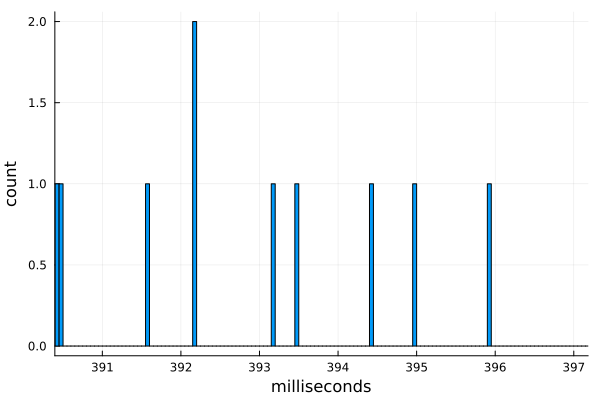

In [40]:
using Statistics # bring in statistical support for standard deviations
t = py_list_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [41]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
[ Warning: julia version requirement for project not satisfied
  No Changes to `~/Work/ic-teach/RCDS-introduction-to-julia/Project.toml`
  No Changes to `~/Work/ic-teach/RCDS-introduction-to-julia/Manifest.toml`


In [42]:
Conda.add("numpy")
numpy_sum = pyimport("numpy")["sum"]


[ Info: Running `conda install -y numpy` in root environment


Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.



PyObject <function sum at 0x16e4d55a0>

In [43]:
numpy_sum(a)

5.001347428625244e6

In [44]:
numpy_sum(a) ≈ sum(a)# type \approx and then <TAB> to get the ≈ symbolb

true

In [45]:
≈  # alias for the `isapprox` function

isapprox (generic function with 18 methods)

In [46]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.


---

```
isapprox(x::FixedPoint, y::FixedPoint; rtol=0, atol=max(eps(x), eps(y)))
```

For FixedPoint numbers, the default criterion is that `x` and `y` differ by no more than `eps`, the separation between adjacent fixed-point numbers.


In [47]:
py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 2560 samples with 1 evaluation.
 Range (min … max):  1.738 ms …   7.470 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.860 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.946 ms ± 293.530 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▆█▄▂▁▂▁                                                     
  █████████▅▄▄▃▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.74 ms         Histogram: frequency by time        2.96 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [48]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 2 entries:
  "Python numpy"    => 1.73838
  "Python built-in" => 390.406

### 3. Python, hand-written 

In [49]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x168d843a0>

In [50]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  484.994 ms …    1.334 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     503.432 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   640.943 ms ± 296.854 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃█                                                             
  ██▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  485 ms           Histogram: frequency by time          1.33 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [51]:
sum_py(a)

5.001347428624898e6

In [52]:
sum_py(a) ≈ sum(a)

true

In [53]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "Python numpy"        => 1.73838
  "Python hand-written" => 484.994
  "Python built-in"     => 390.406

# 4. Julia (built-in) 

## Written directly in Julia, not in C!

In [54]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:994

In [55]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 2983 samples with 1 evaluation.
 Range (min … max):  1.581 ms …  2.666 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.642 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.670 ms ± 93.238 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▃▃▇█▇▄▃▁                                                   
  ██████████▇▇▆▇▆▆▅▆▄▄▃▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂ ▃
  1.58 ms        Histogram: frequency by time        2.08 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [56]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "Python numpy"        => 1.73838
  "Python hand-written" => 484.994
  "Python built-in"     => 390.406
  "Julia built-in"      => 1.58062

# 5. Julia (hand-written) 

In [57]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [58]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 549 samples with 1 evaluation.
 Range (min … max):  8.836 ms …  30.289 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.010 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.111 ms ± 929.026 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▄▃▄▇▅▇█▄▂▁▃▁                                             
  ▃▃▃▆████████████▅▅▃▃▂▅▃▅▃▃▄▄▄▃▅▃▄▅▅▃▃▃▃▂▃▂▁▃▁▁▁▁▁▃▁▂▁▁▂▃▁▁▂ ▄
  8.84 ms         Histogram: frequency by time        9.77 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [59]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "Python numpy"        => 1.73838
  "Julia hand-written"  => 8.836
  "Python hand-written" => 484.994
  "Python built-in"     => 390.406
  "Julia built-in"      => 1.58062

# 6. Julia (hand-written w. simd) 

In [60]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [61]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 2194 samples with 1 evaluation.
 Range (min … max):  2.205 ms …  2.762 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.256 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.276 ms ± 60.743 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃▁▃▆█▆▅▄▄▁▁▁                                              
  ▃█████████████▇▇▆▆▅▅▅▄▄▅▄▄▄▄▄▅▄▄▄▄▃▃▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▂▁▂▁▂ ▄
  2.21 ms        Histogram: frequency by time        2.49 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [62]:
mysum_simd(a)

5.001347428625153e6

In [63]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "Julia hand-written simd" => 2.20512
  "Python numpy"            => 1.73838
  "Julia hand-written"      => 8.836
  "Python hand-written"     => 484.994
  "Python built-in"         => 390.406
  "Julia built-in"          => 1.58062

In [64]:
?@simd

```
@simd
```

Annotate a `for` loop to allow the compiler to take extra liberties to allow loop re-ordering

!!! warning
    This feature is experimental and could change or disappear in future versions of Julia. Incorrect use of the `@simd` macro may cause unexpected results.


The object iterated over in a `@simd for` loop should be a one-dimensional range. By using `@simd`, you are asserting several properties of the loop:

  * It is safe to execute iterations in arbitrary or overlapping order, with special consideration for reduction variables.
  * Floating-point operations on reduction variables can be reordered, possibly causing different results than without `@simd`.

In many cases, Julia is able to automatically vectorize inner for loops without the use of `@simd`. Using `@simd` gives the compiler a little extra leeway to make it possible in more situations. In either case, your inner loop should have the following properties to allow vectorization:

  * The loop must be an innermost loop
  * The loop body must be straight-line code. Therefore, [`@inbounds`](@ref) is   currently needed for all array accesses. The compiler can sometimes turn   short `&&`, `||`, and `?:` expressions into straight-line code if it is safe   to evaluate all operands unconditionally. Consider using the [`ifelse`](@ref)   function instead of `?:` in the loop if it is safe to do so.
  * Accesses must have a stride pattern and cannot be "gathers" (random-index   reads) or "scatters" (random-index writes).
  * The stride should be unit stride.

!!! note
    The `@simd` does not assert by default that the loop is completely free of loop-carried memory dependencies, which is an assumption that can easily be violated in generic code. If you are writing non-generic code, you can use `@simd ivdep for ... end` to also assert that:


  * There exists no loop-carried memory dependencies
  * No iteration ever waits on a previous iteration to make forward progress.


# Summary

In [65]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia built-in..............1.6
Python numpy................1.7
Julia hand-written simd.....2.2
Julia hand-written..........8.8
Python built-in...........390.4
Python hand-written.......485.0


# 7. The C language
C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

In [66]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

clang: warning: argument unused during compilation: '-msse3' [-Wunused-command-line-argument]


c_sum (generic function with 1 method)

In [67]:
c_sum(a)

5.001347428624898e6

In [68]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [69]:
c_sum(a) - sum(a)

-3.4458935260772705e-7

In [70]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 546 samples with 1 evaluation.
 Range (min … max):  8.839 ms …  24.271 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.040 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.157 ms ± 913.024 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▄▃▄▅█▄▅▆ ▃▁                                              
  ▃▄▄▇███████████▆▅▃▄▄▄▃▃▄▃▄▃▄▆▃▃▃▂▃▁▃▃▁▁▃▃▁▃▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂ ▃
  8.84 ms         Histogram: frequency by time        9.98 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [71]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 8.839334 msec


In [72]:
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 7 entries:
  "Julia hand-written simd" => 2.20512
  "Python numpy"            => 1.73838
  "Julia hand-written"      => 8.836
  "C"                       => 8.83933
  "Python hand-written"     => 484.994
  "Python built-in"         => 390.406
  "Julia built-in"          => 1.58062

# 8. C with -ffast-math
If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [73]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

clang: warning: argument unused during compilation: '-msse3' [-Wunused-command-line-argument]


c_sum_fastmath (generic function with 1 method)

In [74]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 3588 samples with 1 evaluation.
 Range (min … max):  1.240 ms …   7.401 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.331 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.387 ms ± 223.707 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂ ▅█▅▅▃▁                                                    
  █████████▇▇▅▄▄▅▄▄▃▄▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  1.24 ms         Histogram: frequency by time        1.96 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [75]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

1.240291

In [76]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............1.2
Julia built-in..............1.6
Python numpy................1.7
Julia hand-written simd.....2.2
Julia hand-written..........8.8
C...........................8.8
Python built-in...........390.4
Python hand-written.......485.0
